### 네이버 주식 데이터 크롤링
- 코스피
- 코스닥
- USD 환율
- 그래프그리기
- 상관계수 확인

#### 크롤링 절차
1. 웹 서비스 분석 : URL 확인
2. request, response : json 데이터(문자열) 억기
3. json 데이터를 dict형태로 파싱 -> 데이터 프레임

In [32]:
code, psize, page = 'KOSPI', 40, 2
url = f'https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code={code}&pageSize={psize}&page={page}'
print(url)

https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=40&page=2


In [35]:
response = requests.get(url)
response

<Response [200]>

In [24]:
# response.text # str

In [23]:
# response.json() # dict

In [25]:
datas = response.json()['result']['siseList']
# datas # 리스트의 딕셔너리 -> DataFrame

In [16]:
kospi_df = pd.DataFrame(datas)
kospi_df.tail(2)

,cd,dt,ncv,cv,cr,ov,hv,lv
38,KOSPI,20191105,2142.64,12.40,0.58,2133.66,2143.12,2128.70
39,KOSPI,20191104,2130.24,30.04,1.43,2111.32,2130.83,2111.32


함수로 만들기

In [26]:
def get_stock_data(code, psize=20, page=1):
    url = f'https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code={code}&pageSize={psize}&page={page}'
    response = requests.get(url)
    datas = response.json()['result']['siseList']
    return pd.DataFrame(datas)

In [27]:
kosdaq_df = get_stock_data('KOSDAQ', 100)
kosdaq_df.tail(2)

,cd,dt,ncv,cv,cr,ov,hv,lv
98,KOSDAQ,20191007,627.21,5.37,0.86,625.25,627.82,622.45
99,KOSDAQ,20191004,621.84,-2.67,-0.43,623.08,627.15,619.53


In [28]:
kospi_df = get_stock_data('KOSPI', 100)
kospi_df.tail(2)

,cd,dt,ncv,cv,cr,ov,hv,lv
98,KOSPI,20191007,2021.73,1.04,0.05,2031.53,2034.94,2016.19
99,KOSPI,20191004,2020.69,-11.22,-0.55,2028.40,2039.43,2020.69


In [48]:
merge_df = pd.merge(kospi_df, kosdaq_df, left_on='dt', right_on='dt')
merge_df = merge_df.rename(columns={'ncv_x': 'ncv_kospi', 'ncv_y': 'ncv_kosdaq'})[
    ['dt', 'ncv_kospi', 'ncv_kosdaq']]
merge_df.tail(2)

,dt,ncv_kospi,ncv_kosdaq
98,20191007,2021.73,627.21
99,20191004,2020.69,621.84


그래프 그리기

In [50]:
import matplotlib.pyplot as plt

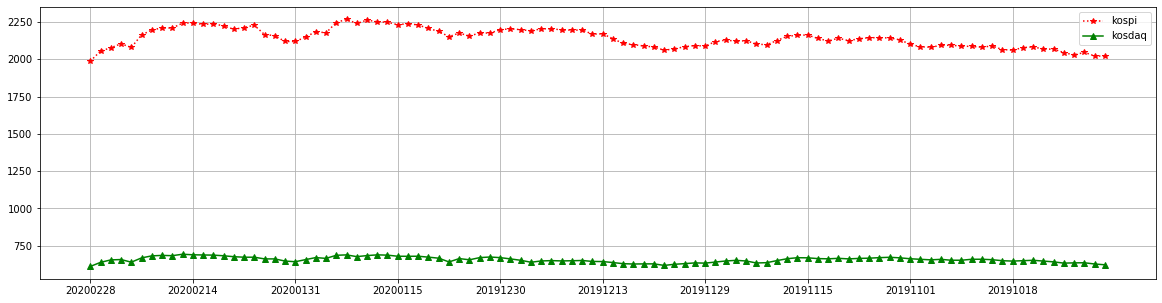

In [66]:
plt.figure(figsize=(20, 5))
plt.plot(merge_df['dt'], merge_df['ncv_kospi'], 'r*:', label='kospi')
plt.plot(merge_df['dt'], merge_df['ncv_kosdaq'], 'g^-', label='kosdaq')

step = len(merge_df) // 10
plt.xticks(merge_df[::step]['dt'])
plt.grid(True)
plt.legend()
plt.show()

정규화 
- `sk.preprocessing.minmax_scale(data)`

In [60]:
from sklearn import preprocessing

In [62]:
kospi_norm = sk.preprocessing.minmax_scale(merge_df['ncv_kospi'])
kosdaq_norm = sk.preprocessing.minmax_scale(merge_df['ncv_kosdaq'])

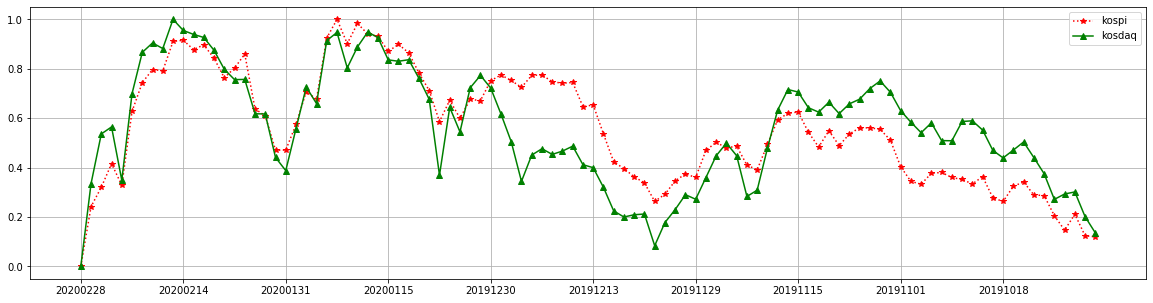

In [67]:
plt.figure(figsize=(20, 5))
plt.plot(merge_df['dt'], kospi_norm, 'r*:', label='kospi')
plt.plot(merge_df['dt'], kosdaq_norm, 'g^-', label='kosdaq')

step = len(merge_df) // 10
plt.xticks(merge_df[::step]['dt'])
plt.grid(True)
plt.legend()
plt.show()

상관계수 구하기

In [69]:
np.corrcoef(merge_df['ncv_kospi'], merge_df['ncv_kosdaq'])[0, 1]

0.8010178642275785

### pygsheet
- 구글 스프레드시트에 크롤링한 데이터 저장, 로드

In [10]:
import zigbang as zb
import pygsheets
import seaborn as sns

In [7]:
# requests, access token
gc = pygsheets.authorize(client_Secret='client_secret.json', no_cache=True)

In [14]:
# 스프레드시트 파일열기
s_file = gc.open('review')

In [11]:
# 붓꽃 데이터 로드
iris_df = sns.load_dataset('iris')
iris_df.tail(2)

,sepal_length,sepal_width,petal_length,petal_width,species
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [15]:
# iris 시트 만들기
iris_sheet = s_file.add_worksheet('iris')

In [16]:
# iris 시트에 데이터 저장
iris_sheet.set_dataframe(iris_df, 'A1')

In [17]:
# 시트삭제
s_file.del_worksheet(s_file[0])

In [18]:
# 직방 데이터를 크롤링해서 저장
addrs = ['연남동', '구의동', '성수동', '화양동']

for addr in addrs:
    print(addr)
    df = zb.crawling_apt(addr)
    sheet = s_file.add_worksheet(addr)
    sheet.set_dataframe(df, 'A1', copy_index=False)

연남동
구의동
성수동
화양동


In [19]:
# 데이터 가져오기
sheet = s_file.worksheet_by_title('구의동')
load_df = sheet.get_as_df()
load_df.tail(2)

,itemId,buildingFloor,groupedItemFloor,lat,lng,sales,itemTitle,m2,p
492,20128039,19,중층,37.540037,127.100097,145000,한강조망이 좋은동으로 학교가 바로 옆에 위치,104,31
493,20127710,18,고층,37.540622,127.098604,130000,최근 올수리로 조용하고 일조건 좋은 매물입니다.,106,32


### Daum 환율정보 크롤링


In [20]:
from fake_useragent import UserAgent

In [21]:
UserAgent().chrome

'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36'

In [24]:
url = 'https://finance.daum.net/api/exchanges/summaries'
headers = {
    'user-agent': UserAgent().chrome,
    'referer': 'https://finance.daum.net/exchanges',
}
response = requests.get(url, headers=headers)
response

<Response [200]>

In [27]:
data = response.json()['data']
result_df = pd.DataFrame(data)
result_df.head(2)

,symbolCode,date,currencyCode,currencyName,currencyUnit,country,region,name,recurrenceCount,basePrice,...,changeRate,cashBuyingPrice,cashSellingPrice,ttBuyingPrice,ttSellingPrice,tcBuyingPrice,fcSellingPrice,exchangeCommission,usDollarRate,chartImageUrl
0,FRX.KRWUSD,2020-02-28 20:02:16,USD,달러,1,미국,"{'korName': '아메리카', 'engName': 'America'}",미국 (KRW/USD),377,1210.50,...,0.001238,1231.68,1189.32,1198.70,1222.30,None,None,3.4311,1.0000,{'day': 'https://t1.daumcdn.net/finance/chart/...
1,FRX.KRWJPY,2020-02-28 20:02:15,JPY,엔,100,일본,"{'korName': '아시아', 'engName': 'Asia'}",일본 (KRW/JPY100),377,1114.18,...,0.012182,1133.67,1094.69,1103.27,1125.09,None,None,1.8730,0.9204,{'day': 'https://t1.daumcdn.net/finance/chart/...


### CSS Selector
- HTML 엘리먼트에 CSS 스타일을 적용시킬 때 엘리먼트를 선택하기 위한 방법
- 선택 방법
    - tag 이름 : `tag`
    - id 값 : `#id`
    - class 값 : `.class`
    - attribute 값 : `[attribute='attr']`
    - 혼합해서 사용 : `tag.class`
    - not selector
        - 선택된 엘리먼트에서 특정 조건의 엘리먼트 제거해서 선택
        - `.class:not(.class)`
    - nth-child
        - n번째 엘리먼트를 선택
        - `.class:nth-child(n)`
---
- 계층구조로 엘리먼트 선택
    - 바로 아래 단계의 엘리먼트 선택
        - `.class > tag`
    - 모든 하위 엘리먼트 선택
        - `.class tag`

### HTML 데이터 파싱을 이용한 크롤링
- 1. URL 찾기
- 2. requests -> response : HTML(str)
- 3. HTML(str) -> BeautifulSoup object (css-selector 사용) -> DataFrame

In [1]:
query = '스펀지밥'
url = f'https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query={query}'
print(url)

https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=스펀지밥


In [2]:
response = requests.get(url)
response

<Response [200]>

In [6]:
dom = BeautifulSoup(response.content, 'html.parser')
type(dom)

bs4.BeautifulSoup

In [15]:
#nx_related_keywords > dl > dd.lst_relate._related_keyword_list > ul
elements = dom.select('._related_keyword_ul > li')
len(elements)

10

In [17]:
elements[0]

<li> <a data-area="*q" data-idx="1" href="?where=nexearch&amp;query=%EC%8A%A4%ED%8F%B0%EC%A7%80%EB%B0%A5&amp;ie=utf8&amp;sm=tab_she&amp;qdt=0">스폰지밥</a> </li>

In [21]:
# keywords = []
# for element in elements:
#     keywords.append(element.text.strip())

# print(keywords)

In [20]:
# list comprehension

keywords = [element.text.strip() for element in elements]
print(keywords)

['스폰지밥', '스펀지밥 다시보기', '스펀지밥 등장인물', '스펀지밥 그리기', '스펀지밥 징징이', '스펀지밥 영어', '스펀지밥 영화', '스펀지밥 캐릭터', '스펀지', '스펀지밥 게임']


In [27]:
# 함수로 만들기
def get_relational_keywords(query):
    url = f'https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query={query}'
    response = requests.get(url)
    dom = BeautifulSoup(response.content, 'html.parser')
    elements = dom.select('._related_keyword_ul > li')
    return [element.text.strip() for element in elements]

In [31]:
print(get_relational_keywords('코로나19'))

['코로나19 증상', '코로나19 사망자', '코로나', '코로나19 확진자', '코로나19 뜻', '코로나19 백신', '코로나19 국내현황', '코로나맵', '코로나나우', '코로나19 사망']


### 다음 뉴스 데이터
- 다음 뉴스 메인페이지 기사 15개 기사의 제목, 링크, 내용 수집

In [69]:
url = 'https://media.daum.net/'

In [70]:
response = requests.get(url)
response

<Response [200]>

In [71]:
dom = BeautifulSoup(response.text, 'html.parser')

In [72]:
elements = dom.select('.list_headline li')
len(elements)

15

In [73]:
elements[0]

<li class="item_main">
<a class="link_cont" href="http://v.media.daum.net/v/20200301133236277">
<span class="wrap_thumb">
<img alt="" class="thumb_g" src="//img1.daumcdn.net/thumb/S189x104ht.u/?fname=https%3A%2F%2Fimg1.daumcdn.net%2Fnews%2F202003%2F01%2Fyonhap%2F20200301133236721ptsg.jpg&amp;scode=media"/>
</span>
<strong class="tit_g">
                                                        범투본, 결국 광화문 아닌 교회에 집결.."우린 반드시 승리"
                        </strong>
</a>
</li>

In [74]:
datas = []
for element in elements:
    datas.append({
        'title': element.select_one('.tit_g').text.strip().replace('\n', ''),
        'link': element.select_one('a').get('href')
    })
articles_df = pd.DataFrame(datas)
articles_df.tail(2)

,title,link
13,"北 ""평안·강원도 의학적 감시대상 7000여명""..자가격리 추정 ...",http://v.media.daum.net/v/20200301124823535
14,장애인의 성적 욕구 무시하는 사회 ...,http://v.media.daum.net/v/20200301124422480


In [75]:
# content 데이터 추가
link = articles_df.loc[0, 'link']
print(link)

http://v.media.daum.net/v/20200301133236277


In [79]:
response = requests.get(link)
dom = BeautifulSoup(response.text, 'html.parser')

In [89]:
content = dom.select_one('#harmonyContainer').text.strip().replace('\n', '')
content

'사랑제일교회 주차장에 마련된 야외 예배석. [유튜브 채널 \'김문수TV\' 캡처]          (서울=연합뉴스) 김다혜 기자 = 서울 광화문광장의 예배 집회를 금지당한 문재인하야범국민투쟁본부(범투본)가 1일 성북구에 있는 사랑제일교회에서 주일 연합예배를 진행했다.이 교회는 범투본 총괄대표인 전광훈 한국기독교총연합회 대표회장 목사가 담임목사로 있는 곳이다.전 목사의 지지자들은 이날 오전 11시께부터 사랑제일교회 예배당과 야외 주차장에 임시로 마련된 예배석에 빼곡히 앉은 채 예배를 하며 구속된 전 목사의 석방을 기원했다. 범투본 관계자들은 예배에 참석하는 신도들이 마스크를 착용하고 방명록을 작성하도록 했고, 성북보건소 직원들도 교회 앞에 나와 입장하는 신도들의 체온을 측정했다. 조나단 목사는 "온 세상이 우한 폐렴(신종 코로나바이러스 감염증·코로나19)으로 덮여 이 자리로 나와 연합예배를 드리게 됨은 하나님의 뜻"이라며 "전국, 세계에서 유튜브로 예배를 드리고 이곳을 향하고 있다"라고 말했다.박중섭 목사는 "우리는 반드시 승리한다"며 "(주여) 무너져가는 이 정권을 다 없애버리고 자유 대한민국을 세워 전광훈 목사님이 속히 (유치장에서) 나올 수 있도록 은혜를 베풀어 주시라"고 말했다. 범투본은 지난해부터 일요일마다 광화문 교보빌딩 앞에서 예배 형식의 집회를 진행해왔다. 서울시가 감염병 예방 및 관리법에 근거해 집회를 금지한 이후인 지난달 23일에도 예배 집회를 강행해 서울시 등에 의해 고발당했다. 그러나 경찰이 집회 및 시위에 관한 법에 근거해 추가로 집회 금지를 통고하고, 법원 역시 경찰의 금지 처분의 집행을 정지해달라는 신청을 기각하자 범투본은 결국 이번 주에는 광화문에서 예배 집회를 하지 않기로 전날 결정했다. 이와 관련 범투본이 광화문광장에서 집회를 하지 못하게 된 것은 그나마 다행이지만, 실내에서 다수가 밀집하는 예배를 하는 것 역시 감염병 예방 차원에서 바람직하지 않다는 지적도 나온다. 조나단 목사는 다수 교회가 코로나19 예방을 위해 오프라인 주

In [92]:
# 함수로 만들기
def get_content(link):
    response = requests.get(link)
    dom = BeautifulSoup(response.text, 'html.parser')
    return dom.select_one('#harmonyContainer').text.strip().replace('\n', '')

In [93]:
articles_df['contents'] = articles_df['link'].apply(get_content)
articles_df.tail(2)

,title,link,contents
13,"北 ""평안·강원도 의학적 감시대상 7000여명""..자가격리 추정 ...",http://v.media.daum.net/v/20200301124823535,[서울=뉴시스] 27일 북한 조선중앙TV가 신종 코로나 바이러스 감염증(코로나19)...
14,장애인의 성적 욕구 무시하는 사회 ...,http://v.media.daum.net/v/20200301124422480,ⓒ이지영 그림 정신분석학자 시몬느 소스는 장애아와 그 가족이 겪는 ...


### msit: 과학기술 정보통신부
- https://www.msit.go.kr/
- 보도자료 크롤링
- json으로 데이터 수집
- json 데이터 안에 html 코드가 들어있음
- json으로 가져온 데이터의 html 코드를 beautifulsoup에 넣어 파싱 후 텍스트로 변환

In [105]:
page = 1

url = f'https://www.msit.go.kr/dynamic/article/_policycom2?sort=operday=desc&below=false&pageout=true&aradon.result.format=json&aradon.page.pageNo={page}&aradon.page.listNum=10&aradon.page.screenCount=5&aradon.referrer.href=https://www.msit.go.kr/web/msipContents/contents.do?mId=MTAxOA==&_=1583043270799'

print(url)

https://www.msit.go.kr/dynamic/article/_policycom2?sort=operday=desc&below=false&pageout=true&aradon.result.format=json&aradon.page.pageNo=1&aradon.page.listNum=10&aradon.page.screenCount=5&aradon.referrer.href=https://www.msit.go.kr/web/msipContents/contents.do?mId=MTAxOA==&_=1583043270799


In [107]:
response = requests.get(url)
response

<Response [200]>

In [115]:
datas = response.json()['result']['nodes']
msit_df = pd.DataFrame(datas)
pd.options.display.max_columns = len(msit_df.columns)
msit_df.tail(1)

,modserno,artcont,orderno,moduserid,hot_date,sync_transaction_sequence,vod_url,catid,modday,artfilenm,useflg,admin_p,hot_check,gourlloc,admin_w,artsubject,admin_t,action,keyword,start_date,thumbnail,creday,partid,reguserid,admin_e,isusingurlloc,catidpath,priority,file_02,file_01,main_on,artid,expireday,c_type,viewcount,operday,catnmpath
9,1,"<p align=""center"" style=""margin: 0px; text-ali...",2961,gwseo777,,5e575654a8e59669c8489231,,_policycom2,20200227-143932,,T,소프트웨어산업과,F,,이태호 사무관,공공 소프트웨어 사업 수·발주자협의체 발족,044-202-6331,INS,,,,20200227-143932,2653526,gwseo777,,F,"[tst1, tsta50, policycom, _policycom2]",5,http://www.msit.go.kr/dynamic/file/afieldfile/...,http://www.msit.go.kr/dynamic/file/afieldfile/...,F,2653526,20470714-120002,SW와 콘텐츠,0,20200227-120002,"[과학기술정보통신부_2019, 과학기술정보통신부 Web, 정책소통, 보도자료]"


In [114]:
msit_df.columns

Index(['modserno', 'artcont', 'orderno', 'moduserid', 'hot_date',
       'sync_transaction_sequence', 'vod_url', 'catid', 'modday', 'artfilenm',
       'useflg', 'admin_p', 'hot_check', 'gourlloc', 'admin_w', 'artsubject',
       'admin_t', 'action', 'keyword', 'start_date', 'thumbnail', 'creday',
       'partid', 'reguserid', 'admin_e', 'isusingurlloc', 'catidpath',
       'priority', 'file_02', 'file_01', 'main_on', 'artid', 'expireday',
       'c_type', 'viewcount', 'operday', 'catnmpath'],
      dtype='object')

In [125]:
columns = ['action', 'admin_p', 'artid', 'artsubject', 'artcont']
msit_df = msit_df[columns]
msit_df.tail(2)

,action,admin_p,artid,artsubject,artcont
8,INS,연구개발정책과,2653527,코로나19 대응을 위한 연구개발사업 가이드라인 마련,"<p align=""center"" style=""margin: 0px; text-ali..."
9,INS,소프트웨어산업과,2653526,공공 소프트웨어 사업 수·발주자협의체 발족,"<p align=""center"" style=""margin: 0px; text-ali..."


In [132]:
msit_df.artcont[0]

'<div style="margin: 0cm 0cm 0pt; text-align: center; line-height: 150%; font-family: &quot;맑은 고딕&quot;;">\r\n<p style="line-height: 150%; font-size: 20pt;">과학기술정보통신부 인사</p></div>\r\n<div style="margin: 0cm 0cm 0pt 10pt; line-height: 115%; text-indent: -10pt; font-family: &quot;맑은 고딕&quot;; font-size: 12pt;">\r\n<p><b>□ 과장급 전보</b></p>\r\n<p>▲ 디지털사회기획과장&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;박 민 하(朴敏夏, 과학기술정보통신부)</p>\r\n<p>▲ 과학기술안전기반팀장&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;조 현 숙(趙顯淑, 과학기술정보통신부)</p>\r\n<p style="text-align: right;"><b>2020. 3. 2.자.</b></p></div>'

In [133]:
# artcont : html형식
html = msit_df.artcont[0]
remove_words = ['\n', '\xa0', '□', '\r', 'ㅇ']
content = BeautifulSoup(html, 'html.parser').text
for remove_word in remove_words:
    content = content.replace(remove_word, '')
content

'과학기술정보통신부 인사 과장급 전보▲ 디지털사회기획과장박 민 하(朴敏夏, 과학기술정보통신부)▲ 과학기술안전기반팀장조 현 숙(趙顯淑, 과학기술정보통신부)2020. 3. 2.자.'

In [134]:
# 함수
def html_to_text(html):
    remove_words = ['\n', '\xa0', '□', '\r', 'ㅇ']
    content = BeautifulSoup(html, 'html.parser').text
    for remove_word in remove_words:
        content = content.replace(remove_word, '')
    return content

In [136]:
msit_df['content'] = msit_df['artcont'].apply(html_to_text)
msit_df.tail(2)

,action,admin_p,artid,artsubject,artcont,content
8,INS,연구개발정책과,2653527,코로나19 대응을 위한 연구개발사업 가이드라인 마련,"<p align=""center"" style=""margin: 0px; text-ali...",코로나19 대응을 위한 연구개발사업 가이드라인 마련- 선정‧단계‧최종 평가 등 평가...
9,INS,소프트웨어산업과,2653526,공공 소프트웨어 사업 수·발주자협의체 발족,"<p align=""center"" style=""margin: 0px; text-ali...",｢공공SW사업 수ㆍ발주자협의체｣ 발족- 소프트웨어 분야 주52시간제 현장안착을 위한...


In [138]:
columns = ['action', 'admin_p', 'artid', 'artsubject', 'artcont']

def get_datas(page):
    for page in range(page + 1):
        url = f'https://www.msit.go.kr/dynamic/article/_policycom2?sort=operday=desc&below=false&pageout=true&aradon.result.format=json&aradon.page.pageNo={page}&aradon.page.listNum=10&aradon.page.screenCount=5&aradon.referrer.href=https://www.msit.go.kr/web/msipContents/contents.do?mId=MTAxOA==&_=1583043270799'
        response = requests.get(url)
        datas = response.json()['result']['nodes']
        msit_df = pd.DataFrame(datas)[columns]
        msit_df['content'] = msit_df['artcont'].apply(html_to_text)
    return msit_df    

In [140]:
get_datas(2).tail(2)

,action,admin_p,artid,artsubject,artcont,content
8,MOD,중이온가속기팀,2649253,"정병선 제1차관, 중이온가속기 건설현장에서의 코로나19 대응태세 점검","<p><font size=""3"">&nbsp;</font></p>\r\n<p alig...","정병선 과기정통부 제1차관, 중이온가속기 건설현장에서의 코로나19 대응태세 점검 정..."
9,MOD,혁신네트워크팀,2649252,2019년 사물인터넷 산업 실태조사 결과 발표,"<p><font size=""3""></font></p>\r\n<p align=""cen...","과기정통부, 2019년 사물인터넷 산업 실태조사 결과 발표- ’19년 사물인터넷 매..."


### mois : 행정안전부 
- https://mois.go.kr/
- 보도자료 데이터 수집
- post 방식 사용
    - dict로 만들어서 함수를 호출할 때 argument로 설정해서 함수 실행 후 가져오기

In [141]:
url = 'https://mois.go.kr/frt/bbs/type010/commonSelectBoardList.do?bbsId=BBSMSTR_000000000008'

In [142]:
# network - headers - form data 
page = 1
params = {
    'nttId': 0,
    'bbsTyCode': 'BBST03',
    'bbsAttrbCode': 'BBSA03',
    'authFlag': 'Y',
    'pageIndex': page,
    'cal_url': '/sym/cal/EgovNormalCalPopup.do',
    'searchCnd': 0,
}
params

{'nttId': 0,
 'bbsTyCode': 'BBST03',
 'bbsAttrbCode': 'BBSA03',
 'authFlag': 'Y',
 'pageIndex': 1,
 'cal_url': '/sym/cal/EgovNormalCalPopup.do',
 'searchCnd': 0}

In [143]:
response = requests.post(url, params)
response

<Response [200]>

In [148]:
dom = BeautifulSoup(response.text, 'html.parser')

In [150]:
elements = dom.select('.table_style1 > tbody > tr')
len(elements)

10

In [151]:
elements[0]

<tr>
<td class="res_hide">
								10625
							</td>
<td class="l">
<div class="wrap">
<a href="/frt/bbs/type010/commonSelectBoardArticle.do;jsessionid=ReO6v--yt7Yt7Md+U6zK1bnT.node10?bbsId=BBSMSTR_000000000008&amp;nttId=76061" onclick="javascript:fn_egov_inqire_notice('76061', 'BBSMSTR_000000000008'); return false;">대구지방합동청사 입주직원, 코로나19 확진 판정 </a>
</div>
</td>
<td class="res_hide">
<img alt="첨부파일" src="/images/board/icon_file.gif;jsessionid=ReO6v--yt7Yt7Md+U6zK1bnT.node10">
</img></td>
<td class="res_hide">
								노사후생과
							</td>
<td>
								2020.02.28.
							</td>
<td class="res_hide">
								462
							</td>
</tr>

In [161]:
elements[0].select_one('td:nth-child(5)')#.text.strip()

<td>
								2020.02.28.
							</td>

In [162]:
datas = []
for element in elements:
    datas.append({
        'no': element.select_one('td:nth-child(1)').text.strip(),
        'title': element.select_one('td:nth-child(2)').text.strip(),
        'writer': element.select_one('td:nth-child(4)').text.strip(),
        'date': element.select_one('td:nth-child(5)').text.strip(),
        'pv': element.select_one('td:nth-child(6)').text.strip(),        
    })
mois_df = pd.DataFrame(datas)
mois_df.tail(2)

,no,title,writer,date,pv
8,10617,"정부청사, 코로나19 유입대비 출입강화, 집중방역 실시",노사후생과,2020.02.24.,660
9,10616,"소하천 토지변경 없으면, 점용허가 끝나도 원상복구 면제",재난경감과,2020.02.24.,494


### naver REST API
- https://developers.naver.com
- 통합검색어 트렌드 api
- 파파고 번역 api